In [1]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

In [2]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt
import seaborn as sns

import os
import ants
from tqdm import tqdm

import umap

In [3]:
df = pd.read_csv('../Data/ABIDE_legend_S982.csv')
patients = df['DxGroup'].values==1
df_asd = df.iloc[patients]
df

,Unnamed: 0,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,...,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Medication Name.1,Off stimulants at EPI scan?,ScanSite,ScannerType,ScannerID,ScanSiteID
0,0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
1,1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
2,2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
3,3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
4,4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,977,1094,sub-985,A00032725,CONTROL,session_1,28,51252,2,0.0,...,NaN,10.99,0.0,NaN,NaN,NaN,ucla,triotim,6,12
978,978,1095,sub-986,A00032704,PATIENT,session_1,28,51229,1,1.0,...,NaN,14.59,0.0,NaN,NaN,NaN,ucla,triotim,6,12
979,979,1096,sub-987,A00032740,CONTROL,session_1,28,51268,2,0.0,...,NaN,17.78,0.0,NaN,NaN,NaN,ucla,triotim,6,12
980,980,1098,sub-989,A00032686,PATIENT,session_1,28,51210,1,1.0,...,NaN,16.56,0.0,NaN,NaN,NaN,ucla,triotim,6,12


In [4]:
# data_latent_vec = np.load('../Data/latent_vecs.npz')
# keys = list(data_latent_vec.keys())
# print(keys)
# for key in keys:
#     print(data_latent_vec[key].shape)

In [4]:
%%time
embed = pickle.load(open('../Data/embedded_data2.pickle','rb'))

FileNotFoundError: [Errno 2] No such file or directory: '../Data/embedded_data2.pickle'

In [5]:
keys = list(embed.keys())
for key in keys:
    try:
        print(f'{key} | {embed[key].shape}')
    except:
        print(f'{key}')

NameError: name 'embed' is not defined

In [7]:
# import umap
# reducer = umap.UMAP()
# embedding_sl = reducer.fit_transform(embed['embedding_sl'])

In [8]:
#embedding_sl = embed['sl_space_abide']
# embedding_sl = embed['reducer_sl_abide'].transform(embed['embedding_sl'])
# x_loading = embedding_sl[:,0]
# y_loading = embedding_sl[:,1]

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding_sl = pca.fit_transform(embed['embedding_sl'])
x_loading = embedding_sl[:,0]
y_loading = embedding_sl[:,1]

In [10]:
keys = ['AgeAtScan','FIQ','ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh']
for key in keys:
    vec = df[key].values[patients]
    e = np.isnan(vec)
    r_x = np.corrcoef(vec[~e],x_loading[~e])[0,1]
    r_y = np.corrcoef(vec[~e],y_loading[~e])[0,1]
    print(f'{key} | X:{r_x:.2f},Y:{r_y:.2f}')

AgeAtScan | X:-0.00,Y:0.02
FIQ | X:-0.05,Y:0.11
ADOS_Total | X:-0.00,Y:-0.10
ADOS_Comm | X:0.05,Y:-0.04
ADOS_Social | X:-0.03,Y:-0.07
ADOS_StBeh | X:-0.14,Y:-0.04


In [11]:
_max = embedding_sl.max(axis=0)
_min = embedding_sl.min(axis=0)
_mid = embedding_sl.mean(axis=0)

# CALC CORNERS
top = (_mid[0],_max[1])
bottom = (_mid[0],_min[1])
left = (_min[0],_mid[1])
right = (_max[0],_mid[1])

top = np.array(top)
bottom = np.array(bottom)
left = np.array(left)
right = np.array(right)


print(f'top | {top}')
print(f'botom | {bottom}')
print(f'left | {left}')
print(f'right | {right}')

top | [-6.898921e-08  5.243964e+00]
botom | [-6.8989209e-08 -3.7231917e+00]
left | [-4.2900763e+00  2.5972406e-07]
right | [4.5916891e+00 2.5972406e-07]


In [12]:
idx_top50 = np.argsort(np.linalg.norm(embedding_sl-top,axis=1))[0:50]
idx_bottom50 = np.argsort(np.linalg.norm(embedding_sl-bottom,axis=1))[0:50]

idx_left50 = np.argsort(np.linalg.norm(embedding_sl-left,axis=1))[0:50]
idx_right50 = np.argsort(np.linalg.norm(embedding_sl-right,axis=1))[0:50]

Text(0.5, 1.0, 'SL SPACE')

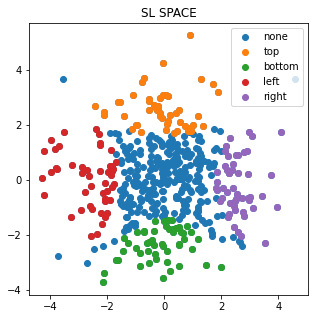

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(embedding_sl[:,0],embedding_sl[:,1])
plt.scatter(embedding_sl[idx_top50,0],embedding_sl[idx_top50,1])
plt.scatter(embedding_sl[idx_bottom50,0],embedding_sl[idx_bottom50,1])
plt.scatter(embedding_sl[idx_left50,0],embedding_sl[idx_left50,1])
plt.scatter(embedding_sl[idx_right50,0],embedding_sl[idx_right50,1])
plt.legend(['none','top','bottom','left','right'])
plt.title('SL SPACE')

In [14]:
subs_top50 = df_asd['BIDS_ID'].values[idx_top50]
subs_bottom50 = df_asd['BIDS_ID'].values[idx_bottom50]
subs_left50 = df_asd['BIDS_ID'].values[idx_left50]
subs_right50 = df_asd['BIDS_ID'].values[idx_right50]

In [15]:
# Save subject list for SPM analyses
pd.DataFrame(
    np.hstack((subs_bottom50[:,np.newaxis],subs_top50[:,np.newaxis])),
    columns=['low','high']).to_csv(
    f'../CSVs/corner_TB.csv')

pd.DataFrame(
    np.hstack((subs_left50[:,np.newaxis],subs_right50[:,np.newaxis])),
    columns=['low','high']).to_csv(
    f'../CSVs/corner_LR.csv')

In [16]:
home = os.getenv("HOME")
j_fn_temp =os.path.join(home,'jacobians/normed_Js_masked/{}_normed_Js_masked.nii')
#j_fn_temp =os.path.join(home,'jacobians/normed_Js/{}_normed_Js.nii')

def glm_second_level(subs_high,subs_low):
    from nilearn.glm import threshold_stats_img
    from nilearn.glm.second_level import SecondLevelModel
    con_name = 't_con'
    
    files_high = [j_fn_temp.format(sub) for sub in subs_high]
    files_low = [j_fn_temp.format(sub) for sub in subs_low]

    second_level_input = files_high+files_low
    nsubs = int(len(second_level_input)/2)
    condition_effect = np.hstack((np.repeat(1,nsubs),np.repeat(-1,nsubs)))

    unpaired_design_matrix = pd.DataFrame(condition_effect[:, np.newaxis],columns=[con_name])
    second_level_model_unpaired = SecondLevelModel().fit(second_level_input, design_matrix=unpaired_design_matrix)

    stat_maps_unpaired = second_level_model_unpaired.compute_contrast(con_name,output_type='all')
    return stat_maps_unpaired,second_level_model_unpaired

In [17]:
def plot_glass_brain(stat_maps_unpaired,threshold=3.1,con_name='t_con',title=None):
    from nilearn import plotting
    display = plotting.plot_glass_brain(
    stat_maps_unpaired, threshold=threshold, colorbar=True, plot_abs=False,
    title=title, vmin=0, vmax=6)

In [18]:
stat_maps_TB,model_TB = glm_second_level(subs_top50,subs_bottom50)
stat_maps_LR,model_LR = glm_second_level(subs_left50,subs_right50)

/data/aglinska/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning:

The nilearn.glm module is experimental. It may change in any future release of Nilearn.



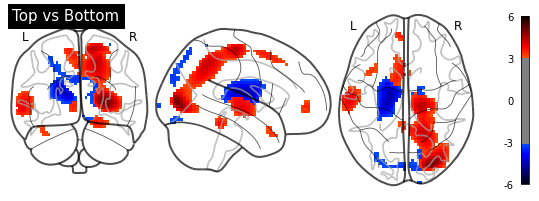

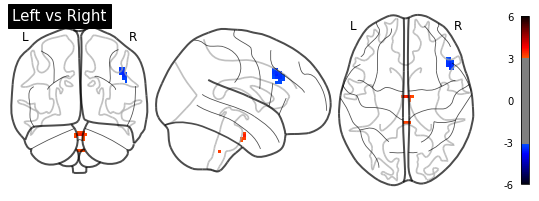

In [19]:
plot_glass_brain(stat_maps_TB['z_score'],title='Top vs Bottom')
plot_glass_brain(stat_maps_LR['z_score'],title='Left vs Right')

In [20]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

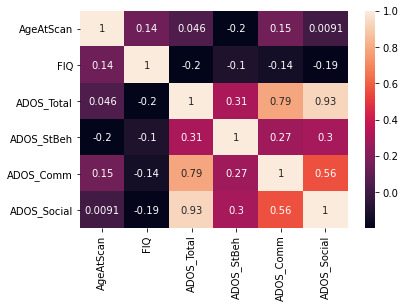

In [21]:
use_keys = ['AgeAtScan','FIQ','ADOS_Total','ADOS_StBeh', 'ADOS_Comm', 'ADOS_Social']
base_corr = np.zeros((len(use_keys),len(use_keys)))
for i1,key1 in enumerate(use_keys):
    for i2,key2 in enumerate(use_keys):
        vec1=df[key1].values[patients]
        vec2=df[key2].values[patients]
        e = np.isnan(vec1)+np.isnan(vec2)
        r = np.corrcoef(vec1[~e],vec2[~e])[0,1]
        base_corr[i1,i2] = r
        
sns.heatmap(base_corr,xticklabels=use_keys,yticklabels=use_keys,annot=True);